# Occlusion Analysis

Measures the importance of each area in an each for making a match between a query-key pair

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import numpy as np
import torchvision.transforms as tf
from matplotlib import pyplot as plt

#we're using the captum library to compute
#the occlusion analysis
from captum.attr import Occlusion

In [3]:
#local import of a few functions/classes
from occlusion_helpers import *

In [4]:
#pick best available device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#download the CellEMNet weights and load them
#into the MoCo resnet50 model
model, norms = load_pretrained_cellemnet()

#we only need the query encoder (encoder_k)
#is the key encoder
model_q = model.encoder_q.to(device)
model_q = model_q.eval()

In [5]:
#set normalization parameter
normalize = tf.Normalize(mean=[norms[0]], std=[norms[1]])

#create transform class
aug = tf.Compose([
    tf.Grayscale(1),
    tf.RandomResizedCrop(224, scale=(0.2, 1.)),
    tf.RandomHorizontalFlip(),
    tf.RandomVerticalFlip(),
    tf.ToTensor(),
    normalize
])

#creat the dataset
dataset = DataFolder('example_data/occlusion/', aug)

Found 10 images in example_data/occlusion/


In [14]:
#randomly generate the query and key images
#index picks an image in the dataset any number from 0-9 is OK
index = 5
image1, image2 = dataset[index]

#overwrite the decoder to hardcode
#image2 such that the only argument to forward
#is image1. The Occlusion class cannot handle
#multiple inputs correctly
class Decoder(DefaultDecoder):
    def __init__(self, encoder):
        super(Decoder, self).__init__(encoder)
        
    def forward(self, image1):
        with torch.no_grad():
            key = self.encoder(image2.unsqueeze(0).to(device))
        query = self.encoder(image1)
        return self.compare_encodings(query, key)
    
#create the decoder on device
decoder = Decoder(model_q).to(device)
decoder = decoder.eval()

#perform the occlusion analysis
#adjust the stride and sliding window shapes
#to pick of larger or smaller regions that are
#important
occlusion = Occlusion(decoder)
attributions_occ = occlusion.attribute(
    image1.unsqueeze(0).to(device), strides=(1, 15, 15),
    sliding_window_shapes=(1, 31, 31), baselines=0
)

#rescale to a numpy array in range [0-1]
#(1, 1, H, W) --> (H, W)
attributions_occ = rescale(attributions_occ.squeeze().detach().cpu())

Text(0.5, 1.0, 'Reference Image (key)')

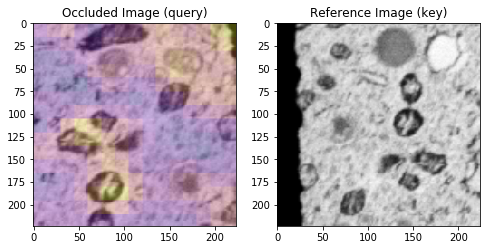

In [15]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(image1[0], cmap='gray')
ax[0].imshow(attributions_occ, alpha=0.3, cmap='plasma')
ax[0].set_title('Occluded Image (query)')
ax[1].imshow(image2[0], cmap='gray')
ax[1].set_title('Reference Image (key)')